<a href="https://colab.research.google.com/github/gugaio/lllms/blob/main/Lilt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 10.6 MB/s eta 0:00:00


In [1]:
# ubuntu
!sudo apt install -y tesseract-ocr
# python
!pip install pytesseract transformers datasets seqeval tensorboard evaluate --upgrade

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 19 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 0s (31.4 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debco

In [2]:
# install git-fls for pushing model and logs to the hugging face hub
!sudo apt-get install git-lfs --yes

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.


In [3]:
from huggingface_hub import notebook_login

notebook_login()

In [4]:
from datasets import load_dataset

In [5]:
dataset_id ="nielsr/funsd-layoutlmv3"
dataset = load_dataset(dataset_id)

print(f"Train dataset size: {len(dataset['train'])}")
print(f"Test dataset size: {len(dataset['test'])}")

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Train dataset size: 149
Test dataset size: 50


In [6]:
dataset['train'].features

{'id': Value(dtype='string', id=None),
 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'bboxes': Sequence(feature=Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), length=-1, id=None),
 'ner_tags': Sequence(feature=ClassLabel(names=['O', 'B-HEADER', 'I-HEADER', 'B-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER'], id=None), length=-1, id=None),
 'image': Image(decode=True, id=None)}

In [7]:
"ID: %s" % dataset['train'][0]['id']

'ID: 0'

In [8]:
print("Total de Bboxes: %s. Primeiro:  [0] %s" % (len(dataset['train'][0]['bboxes']), dataset['train'][0]['bboxes'][0]))
print("Total de Tokens: %s. Primeiro:  [0] %s" % (len(dataset['train'][0]['tokens']), dataset['train'][0]['tokens'][0]))
print("Total de ner_tags: %s. Primeiro:  [0] %s" % (len(dataset['train'][0]['ner_tags']), dataset['train'][0]['ner_tags'][0]))

Total de Bboxes: 145. Primeiro:  [0] [383, 91, 493, 175]
Total de Tokens: 145. Primeiro:  [0] R&D
Total de ner_tags: 145. Primeiro:  [0] 0


In [9]:
type(dataset['train'][0]['image'])

PIL.PngImagePlugin.PngImageFile

Analisando os Labels de cada token

In [6]:
labels = dataset['train'].features['ner_tags'].feature.names
print(f"Available labels: {labels}")

id2label = {i: v for i, v in enumerate(labels)}
label2id = {v: i for i, v in enumerate(labels)}
#    Available labels: ['O', 'B-HEADER', 'I-HEADER', 'B-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER']

Available labels: ['O', 'B-HEADER', 'I-HEADER', 'B-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER']


Implementar o Process que irá fazer o encoding do dataset

In [7]:
from transformers import LayoutLMv3FeatureExtractor, AutoTokenizer, LayoutLMv3Processor

model_id="SCUT-DLVCLab/lilt-roberta-en-base"

# use LayoutLMv3 processor without ocr since the dataset already includes the ocr text
feature_extractor = LayoutLMv3FeatureExtractor(apply_ocr=False) # set
tokenizer = AutoTokenizer.from_pretrained(model_id)
# cannot use from_pretrained since the processor is not saved in the base model
processor = LayoutLMv3Processor(feature_extractor, tokenizer)

/usr/local/lib/python3.10/dist-packages/transformers/models/layoutlmv3/feature_extraction_layoutlmv3.py:30: FutureWarning: The class LayoutLMv3FeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use LayoutLMv3ImageProcessor instead.
  warnings.warn(


In [8]:
from PIL import Image
from functools import partial
from datasets import Features, Sequence, ClassLabel, Value, Array2D

Mapping do dataset original para o dataset processado que será utilizado pelo Model

In [9]:
# we need to define custom features
features = Features(
    {
        "input_ids": Sequence(feature=Value(dtype="int64")),
        "attention_mask": Sequence(feature=Value(dtype="int64")),
        "bbox": Array2D(dtype="int64", shape=(512, 4)),
        "labels": Sequence(ClassLabel(names=labels)),
    }
)

# preprocess function to perpare into the correct format for the model
def process(sample, processor=None):
    encoding = processor(
        sample["image"].convert("RGB"),
        sample["tokens"],
        boxes=sample["bboxes"],
        word_labels=sample["ner_tags"],
        padding="max_length",
        truncation=True,
    )
    # remove pixel values not needed for LiLT
    del encoding["pixel_values"]
    return encoding


# process the dataset and format it to pytorch
proc_dataset = dataset.map(
    partial(process, processor=processor),
    remove_columns=["image", "tokens", "ner_tags", "id", "bboxes"],
    features=features,
).with_format("torch")

print(proc_dataset["train"].features.keys())
# dict_keys(['input_ids', 'attention_mask', 'bbox','lables'])

Map:   0%|          | 0/149 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

dict_keys(['input_ids', 'attention_mask', 'bbox', 'labels'])


In [14]:
print("Total de Token Ids: %s. Primeiro:  %s" % (len(proc_dataset['train'][0]['input_ids']), proc_dataset['train'][0]['input_ids'][1]))
print("Total de Bboxes: %s. Primeiro:  %s" % (len(proc_dataset['train'][0]['bbox']), proc_dataset['train'][0]['bbox'][1]))
print("Total de Attention Masks: %s. Primeiro:  %s" % (len(proc_dataset['train'][0]['attention_mask']), proc_dataset['train'][0]['attention_mask'][1]))
print("Total de labels: %s. Primeiro:  %s" % (len(proc_dataset['train'][0]['labels']), proc_dataset['train'][0]['labels'][1]))

Total de Token Ids: 512. Primeiro:  tensor(248)
Total de Bboxes: 512. Primeiro:  tensor([383,  91, 493, 175])
Total de Attention Masks: 512. Primeiro:  tensor(1)
Total de labels: 512. Primeiro:  tensor(0)


Fine-tune

In [11]:
from transformers import LiltForTokenClassification

In [12]:
# huggingface hub model id
model_id = "SCUT-DLVCLab/lilt-roberta-en-base"

# load model with correct number of labels and mapping
model = LiltForTokenClassification.from_pretrained(
    model_id, num_labels=len(labels), label2id=label2id, id2label=id2label
)

Some weights of LiltForTokenClassification were not initialized from the model checkpoint at SCUT-DLVCLab/lilt-roberta-en-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Metricas

In [13]:
import evaluate
import numpy as np

# load seqeval metric
metric = evaluate.load("seqeval")

# labels of the model
ner_labels = list(model.config.id2label.values())
print(ner_labels)

['O', 'B-HEADER', 'I-HEADER', 'B-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER']


In [14]:
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    all_predictions = []
    all_labels = []
    for prediction, label in zip(predictions, labels):
        for predicted_idx, label_idx in zip(prediction, label):
            if label_idx == -100:
                continue
            all_predictions.append(ner_labels[predicted_idx])
            all_labels.append(ner_labels[label_idx])
    return metric.compute(predictions=[all_predictions], references=[all_labels])


In [17]:
from huggingface_hub import HfFolder
from transformers import Trainer, TrainingArguments

# hugging face parameter
repository_id = "gugaime/dokki-lilt"

# Define training args
training_args = TrainingArguments(
    output_dir=repository_id,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    fp16=True,
    learning_rate=5e-5,
    max_steps=600,
    # logging & evaluation strategies
    logging_dir=f"{repository_id}/logs",
    logging_strategy="steps",
    logging_steps=100,
    evaluation_strategy="steps",
    save_strategy="steps",
    save_steps=200,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="overall_f1",
    # push to hub parameters
    report_to="tensorboard",
    push_to_hub=True,
    hub_strategy="every_save",
    hub_model_id=repository_id,
    hub_token=HfFolder.get_token(),
)

In [18]:
# Create Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=proc_dataset["train"],
    eval_dataset=proc_dataset["test"],
    compute_metrics=compute_metrics,
)

In [19]:
trainer.train()

Step,Training Loss,Validation Loss,Answer,Header,Question,Overall Precision,Overall Recall,Overall F1,Overall Accuracy
100,0.692700,0.769560,"{'precision': 0.7593582887700535, 'recall': 0.8690330477356181, 'f1': 0.8105022831050229, 'number': 817}","{'precision': 0.5166666666666667, 'recall': 0.2605042016806723, 'f1': 0.3463687150837989, 'number': 119}","{'precision': 0.8429973238180196, 'recall': 0.8774373259052924, 'f1': 0.8598726114649682, 'number': 1077}",0.796786,0.837556,0.816663,0.778200
200,0.159800,1.023456,"{'precision': 0.8254504504504504, 'recall': 0.8971848225214198, 'f1': 0.859824046920821, 'number': 817}","{'precision': 0.6097560975609756, 'recall': 0.42016806722689076, 'f1': 0.4975124378109453, 'number': 119}","{'precision': 0.8744313011828936, 'recall': 0.8922934076137419, 'f1': 0.8832720588235293, 'number': 1077}",0.842919,0.866369,0.854483,0.786283
300,0.053600,1.115651,"{'precision': 0.8597785977859779, 'recall': 0.8555691554467564, 'f1': 0.8576687116564417, 'number': 817}","{'precision': 0.5789473684210527, 'recall': 0.46218487394957986, 'f1': 0.514018691588785, 'number': 119}","{'precision': 0.8663793103448276, 'recall': 0.9331476323119777, 'f1': 0.8985248100134109, 'number': 1077}",0.850580,0.873820,0.862044,0.808273
400,0.022300,1.216674,"{'precision': 0.8367117117117117, 'recall': 0.9094247246022031, 'f1': 0.8715542521994134, 'number': 817}","{'precision': 0.5149253731343284, 'recall': 0.5798319327731093, 'f1': 0.5454545454545455, 'number': 119}","{'precision': 0.8898148148148148, 'recall': 0.8922934076137419, 'f1': 0.8910523875753361, 'number': 1077}",0.843482,0.880775,0.861725,0.808273
500,0.009400,1.231261,"{'precision': 0.8564760793465578, 'recall': 0.8984088127294981, 'f1': 0.8769414575866189, 'number': 817}","{'precision': 0.6534653465346535, 'recall': 0.5546218487394958, 'f1': 0.6000000000000001, 'number': 119}","{'precision': 0.8853790613718412, 'recall': 0.9108635097493036, 'f1': 0.8979405034324943, 'number': 1077}",0.862052,0.884749,0.873253,0.816118
600,0.005100,1.273203,"{'precision': 0.859504132231405, 'recall': 0.8910648714810282, 'f1': 0.8750000000000001, 'number': 817}","{'precision': 0.6355140186915887, 'recall': 0.5714285714285714, 'f1': 0.6017699115044248, 'number': 119}","{'precision': 0.886672710788758, 'recall': 0.9080779944289693, 'f1': 0.8972477064220182, 'number': 1077}",0.862421,0.881272,0.871744,0.813265


Trainer is attempting to log a value of "{'precision': 0.7593582887700535, 'recall': 0.8690330477356181, 'f1': 0.8105022831050229, 'number': 817}" of type <class 'dict'> for key "eval/ANSWER" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.5166666666666667, 'recall': 0.2605042016806723, 'f1': 0.3463687150837989, 'number': 119}" of type <class 'dict'> for key "eval/HEADER" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.8429973238180196, 'recall': 0.8774373259052924, 'f1': 0.8598726114649682, 'number': 1077}" of type <class 'dict'> for key "eval/QUESTION" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.8254504504504504, 'recall': 0.8971848

TrainOutput(global_step=600, training_loss=0.15714156299829482, metrics={'train_runtime': 127.2123, 'train_samples_per_second': 37.732, 'train_steps_per_second': 4.717, 'total_flos': 1309312249592832.0, 'train_loss': 0.15714156299829482, 'epoch': 31.58})

In [17]:
trainer.evaluate()

Trainer is attempting to log a value of "{'precision': 0.879951980792317, 'recall': 0.8971848225214198, 'f1': 0.8884848484848484, 'number': 817}" of type <class 'dict'> for key "eval/ANSWER" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.5934065934065934, 'recall': 0.453781512605042, 'f1': 0.5142857142857143, 'number': 119}" of type <class 'dict'> for key "eval/HEADER" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.8935599284436494, 'recall': 0.9275766016713092, 'f1': 0.910250569476082, 'number': 1077}" of type <class 'dict'> for key "eval/QUESTION" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 1.7113450765609741,
 'eval_ANSWER': {'precision': 0.879951980792317,
  'recall': 0.8971848225214198,
  'f1': 0.8884848484848484,
  'number': 817},
 'eval_HEADER': {'precision': 0.5934065934065934,
  'recall': 0.453781512605042,
  'f1': 0.5142857142857143,
  'number': 119},
 'eval_QUESTION': {'precision': 0.8935599284436494,
  'recall': 0.9275766016713092,
  'f1': 0.910250569476082,
  'number': 1077},
 'eval_overall_precision': 0.8746327130264446,
 'eval_overall_recall': 0.8872329855936413,
 'eval_overall_f1': 0.8808877928483353,
 'eval_overall_accuracy': 0.7938904077023654,
 'eval_runtime': 0.4846,
 'eval_samples_per_second': 103.178,
 'eval_steps_per_second': 14.445,
 'epoch': 131.58}

In [97]:
notebook_login()

Push model to HG

In [79]:
# change apply_ocr to True to use the ocr text for inference
processor.feature_extractor.apply_ocr = False


/usr/local/lib/python3.10/dist-packages/transformers/models/layoutlmv3/processing_layoutlmv3.py:194: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


In [20]:
processor.save_pretrained(repository_id)
trainer.create_model_card()
trainer.push_to_hub()

events.out.tfevents.1699027772.e1e60ff71383.417.0:   0%|          | 0.00/8.93k [00:00<?, ?B/s]

'https://huggingface.co/gugaime/dokki-lilt/tree/main/'

In [21]:
from transformers import LiltForTokenClassification, LayoutLMv3Processor
from PIL import Image, ImageDraw, ImageFont
import torch

# load model and processor from huggingface hub
model = LiltForTokenClassification.from_pretrained("gugaime/dokki-lilt")
processor = LayoutLMv3Processor.from_pretrained("gugaime/dokki-lilt")

In [22]:
from PIL import Image, ImageDraw, ImageFont

# Your code using ImageDraw here


In [23]:
def unnormalize_box(bbox, width, height):
    return [
        width * (bbox[0] / 1000),
        height * (bbox[1] / 1000),
        width * (bbox[2] / 1000),
        height * (bbox[3] / 1000),
    ]


label2color = {
    "B-HEADER": "blue",
    "B-QUESTION": "red",
    "B-ANSWER": "green",
    "I-HEADER": "blue",
    "I-QUESTION": "red",
    "I-ANSWER": "green",
}
# draw results onto the image
def draw_boxes(image, boxes, predictions):
    width, height = image.size
    normalizes_boxes = [unnormalize_box(box, width, height) for box in boxes]

    # draw predictions over the image
    draw = ImageDraw.Draw(image)
    font = ImageFont.load_default()
    for prediction, box in zip(predictions, normalizes_boxes):
        if prediction == "O":
            continue
        draw.rectangle(box, outline="black")
        draw.rectangle(box, outline=label2color[prediction])
        draw.text((box[0] + 10, box[1] - 10), text=prediction, fill=label2color[prediction], font=font)
    return image

In [24]:
def run_inference(image, tokens, bboxes, model=model, processor=processor, output_image=True):
    # create model input
    encoding = processor(image, tokens, boxes=bboxes, return_tensors="pt")
    del encoding["pixel_values"]
    # run inference
    outputs = model(**encoding)
    predictions = outputs.logits.argmax(-1).squeeze().tolist()
    # get labels
    labels = [model.config.id2label[prediction] for prediction in predictions]
    if output_image:
        return draw_boxes(image, encoding["bbox"][0], labels)
    else:
        return labels

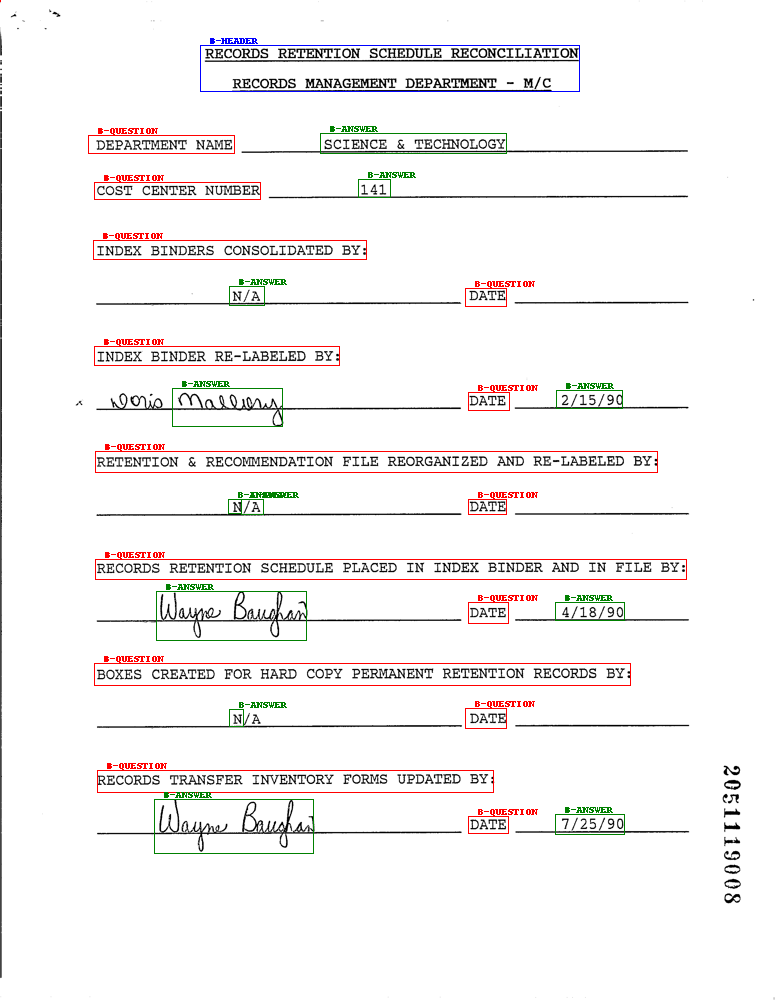

In [25]:
run_inference(dataset["test"][34]["image"], dataset["test"][34]["tokens"], dataset["test"][34]["bboxes"])